# Pengenalan Genre Lagu

# Instalasi dan Impor Library

## Instalasi Dependensi

libsndfile1 diperlukan untuk membaca file audio dalam berbagai format (terutama .wav) menggunakan soundfile.

In [ ]:
#Menginstall Library libsndfile1
!apt-get install libsndfile1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


## Impor Library

Adapun library yang digunakan pada projek ini yakni:
1. os → Untuk manipulasi path file dan folder.
2. numpy → Untuk operasi numerik.
3. librosa → Untuk pemrosesan sinyal audio.
4. soundfile → Untuk membaca file audio.
5. matplotlib & seaborn → Untuk visualisasi.
6. scikit-learn → Untuk pembelajaran mesin, preprocessing, dan evaluasi model.

In [ ]:
#Mengimpor Library yang digunakan
import os
import numpy as np
import pandas as pd

import librosa
import soundfile as sf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Definisi Path Dataset

Penentuan path dari dataset beserta genre dari lagu yang ada. Adapun penjelasan singkatnya sebagai berikut:
1. DATASET_PATH → Menentukan lokasi dataset genre musik.
2. GENRES → List genre yang akan digunakan untuk klasifikasi.

In [ ]:
import gdown

file_id = "1BM0EXG1f-sWfqZKR56JtnTnxV489mU0p"  # Ganti dengan file ID dataset kamu
output_path = "/content/dataset.zip"  # Nama file output

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

print('Data source import complete.')

Downloading...
From (original): https://drive.google.com/uc?id=1BM0EXG1f-sWfqZKR56JtnTnxV489mU0p
From (redirected): https://drive.google.com/uc?id=1BM0EXG1f-sWfqZKR56JtnTnxV489mU0p&confirm=t&uuid=8df0ba90-f82d-4523-a079-135b03ee73fe
To: /content/dataset.zip
100%|██████████| 1.30G/1.30G [00:17<00:00, 72.6MB/s]

Data source import complete.


Unzip Document

In [ ]:
import zipfile

dataset_path = "/content/dataset.zip"
extract_path = "/content/genre_dataset/"  # Folder tujuan ekstraksi

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset telah diekstrak ke: {extract_path}")

Dataset telah diekstrak ke: /content/genre_dataset/


In [ ]:
# Menampilkan isi folder
print("Daftar file dalam dataset:")
print(os.listdir(extract_path))

Daftar file dalam dataset:
['Data Genre Musik']


In [ ]:
#Path ke dataset
DATASET_PATH = "/content/genre_dataset/Data Genre Musik/genres_original"
GENRES = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

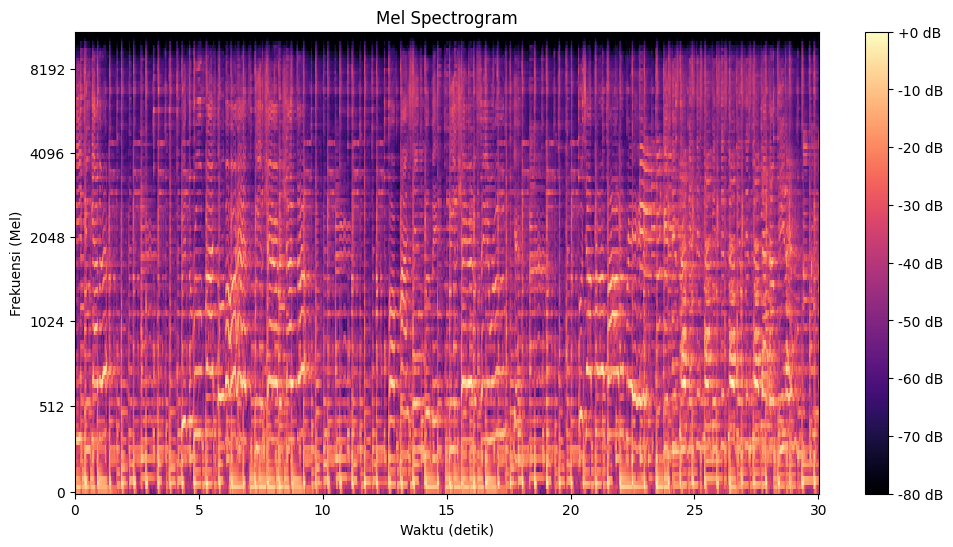

In [ ]:
# Load file audio
file_path = "/content/genre_dataset/Data Genre Musik/genres_original/reggae/reggae.00000.wav"  # Ganti dengan path file audio
yy, sr = librosa.load(file_path, sr=None)

# Compute Mel Spectrogram
mel_spec = librosa.feature.melspectrogram(y=yy, sr=sr, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot Mel Spectrogram
plt.figure(figsize=(12, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectrogram")
plt.xlabel("Waktu (detik)")
plt.ylabel("Frekuensi (Mel)")
plt.show()

# Ekstraksi Fitur dari Audio (MFCC)

Ekstraksi fitur yang dilakukan pada projek ini yakni:
1. Load Audio
    *   Menggunakan soundfile.read() untuk membaca file audio.
    *   Jika audio stereo, dikonversi ke mono dengan rata-rata kedua channel.

2. Normalisasi Sample Rate
    *   Jika sample rate bukan 22050 Hz, maka audio di-resample.

3. Durasi Tetap (30 detik)
    *   Jika audio kurang dari 30 detik, akan dipadatkan dengan nol (np.pad).
    *   Jika lebih panjang, akan dipotong.

4. Ekstraksi MFCC (Mel-Frequency Cepstral Coefficients)
    *   librosa.feature.mfcc() mengekstrak 13 koefisien MFCC.
    *   Nilai rata-rata MFCC dari seluruh frame digunakan sebagai fitur.





In [ ]:
# 📌 Fungsi untuk ekstraksi fitur MFCC dari file audio
def extract_features(file_path, max_length=30, sr=22050):
    try:
        # 🔄 Load file audio menggunakan soundfile
        y, sr = sf.read(file_path, dtype="float32")

        # Jika audio stereo, konversi ke mono
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)

        # Normalisasi sample rate jika tidak sesuai
        if sr != 22050:
            y = librosa.resample(y, orig_sr=sr, target_sr=22050)
            sr = 22050

        # ✂️ Potong atau pad file agar berdurasi tetap
        target_length = max_length * sr
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        else:
            y = y[:target_length]

        # 🎵 Ekstraksi MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc = np.mean(mfcc.T, axis=0)  # Ambil rata-rata setiap koefisien MFCC

        return mfcc
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

# Load Dataset & Ekstraksi Fitur

Memuat dataset dan hasil ekstraksi fitur dengan penjelasan singkat sebagai berikut:
1. Iterasi setiap genre dalam dataset.
2. Load setiap file audio dan ekstrak fitur MFCC.
3. Label genre dikonversi menjadi angka sesuai dengan indeks di list GENRES.

In [ ]:
# Load dataset & ekstraksi fitur
X, y = [], []

for genre in GENRES:
    genre_path = os.path.join(DATASET_PATH, genre)

    for file_name in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file_name)

        features = extract_features(file_path)
        if features is not None:
            X.append(features)
            y.append(GENRES.index(genre))  # Label numerik berdasarkan indeks genre


❌ Error loading /content/genre_dataset/Data Genre Musik/genres_original/jazz/jazz.00054.wav: Error opening '/content/genre_dataset/Data Genre Musik/genres_original/jazz/jazz.00054.wav': Format not recognised.


# Konversi Data ke Format Numpy

Melakukan konversi data ke format numpy, dimana Data X (MFCC) dan y (label genre) dikonversi ke array numpy.

In [ ]:
# Konversi ke numpy array
X = np.array(X)
y = np.array(y)

Menyimpan hasil ekstraksi fitur dengan format CSV

In [ ]:
# Simpan X dan y ke dalam DataFrame
df_Xy = pd.DataFrame(X)  # Simpan fitur
df_Xy['label'] = y        # Tambahkan kolom label

# Simpan ke CSV
df_Xy.to_csv('/content/Xy_dataset.csv', index=False)

print("Dataset X dan y telah disimpan sebagai 'Xy_dataset.csv'")

Dataset X dan y telah disimpan sebagai 'Xy_dataset.csv'


In [ ]:
# Baca kembali dataset
df_check = pd.read_csv('/content/Xy_dataset.csv')

df_check

,0,1,2,3,4,5,6,7,8,9,10,11,12,label
0,-149.975890,93.640755,6.336245,71.511150,-8.113177,36.212020,-9.784972,17.641598,-21.119005,-0.125904,-22.200990,5.435663,-7.467778,0
1,-212.815400,139.069230,9.454345,35.446270,12.709547,20.417665,-5.573953,10.893662,-8.731712,8.055455,0.163798,2.641746,-1.025734,0
2,-227.268860,137.730700,-14.493464,63.555702,5.612646,11.984635,1.885557,-1.863381,-7.620551,-2.447179,-2.886721,-9.429532,-10.923910,0
3,-350.358900,169.546330,31.780243,16.713753,28.661757,19.249092,7.846701,10.039793,4.742697,2.915623,3.896542,1.810350,-5.970981,0
4,-249.289400,130.987030,0.677392,66.685780,17.897808,4.623735,6.598311,1.249048,1.416391,-1.579143,-0.962662,-3.571996,-2.927982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-193.562990,98.399030,44.057728,23.779394,12.564506,8.460669,2.171391,-0.346506,-8.192859,-9.118402,-5.235873,-4.838527,-1.370821,9
995,-56.943455,115.210540,-30.444605,37.203808,-21.994804,21.870764,-19.770649,14.999988,-24.074703,17.787264,-17.278640,6.752428,-10.744573,9
996,-88.000725,93.537320,-23.228851,48.129993,-21.446268,27.758793,-20.340559,18.754475,-15.226568,16.130507,-21.412472,10.874083,-12.021344,9
997,-142.484680,116.168920,2.269468,31.065388,6.192661,0.110362,0.317253,7.794024,3.246235,-3.022173,1.710509,0.742647,0.142906,9


# Pembagian Data Training & Testing

Melakukan pembagian data pelatihan dan pengetesan dengan penjelasan sebagai berikut:
1. Data dibagi menjadi:
    *   80% training (X_train, y_train)
    *   20% testing (X_test, y_test)

2. Parameter stratify=y memastikan proporsi genre tetap seimbang di training dan testing.

In [ ]:
# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalisasi Data

Melakukan normalisasi data dengan penjelasan sebagai berikut:
1. Standardisasi fitur menggunakan StandardScaler().
2. Mean dari fitur menjadi 0, standar deviasi menjadi 1.

In [ ]:
# Normalisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pelatihan dan Prediksi

## Training Model SVM

Melatih model menggunakan *Support Vector Machine* (SVM), dengan penjelasan setiap bagiannya adalah sebagai berikut:
1. SVM (Support Vector Machine) dengan kernel RBF digunakan untuk klasifikasi.
2. C=10 → Mengontrol kompleksitas model.
3. gamma='scale' → Menentukan seberapa jauh pengaruh satu contoh pelatihan.

In [ ]:
# Training model SVM
svm_model = SVC(kernel='rbf', C=10, gamma='scale')
svm_model.fit(X_train, y_train)

SVC(C=10)

## Prediksi & Evaluasi Model

Pada langkah ini, model melakukan prediksi genre untuk dataset testing.

In [ ]:
# Prediksi & Evaluasi
y_pred = svm_model.predict(X_test)

# Evaluasi Model

## Evaluasi Akurasi

Melakukan evaluasi model dengan penjelasan sebagai berikut:
1. Menghitung akurasi model menggunakan accuracy_score().
2. Menampilkan laporan klasifikasi (precision, recall, f1-score) per genre.

In [ ]:
# Evaluasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi Model: {accuracy:.4f}')
print(classification_report(y_test, y_pred, target_names=GENRES))

Akurasi Model: 0.6700
              precision    recall  f1-score   support

       blues       0.78      0.70      0.74        20
   classical       0.90      0.95      0.93        20
     country       0.50      0.60      0.55        20
       disco       0.57      0.60      0.59        20
      hiphop       0.53      0.50      0.51        20
        jazz       0.71      0.60      0.65        20
       metal       0.70      0.80      0.74        20
         pop       0.89      0.85      0.87        20
      reggae       0.59      0.65      0.62        20
        rock       0.56      0.45      0.50        20

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.67      0.67      0.67       200



## Confusion Matrix

Selain menghitung metrik evaluasi, performa model juga dinilai dari *Confusion Matrix*. Adapun penjelasan singkatnya adalah sebagai berikut:
1. Membuat confusion matrix untuk melihat kesalahan prediksi.
2. Heatmap visualisasi menggunakan Seaborn.

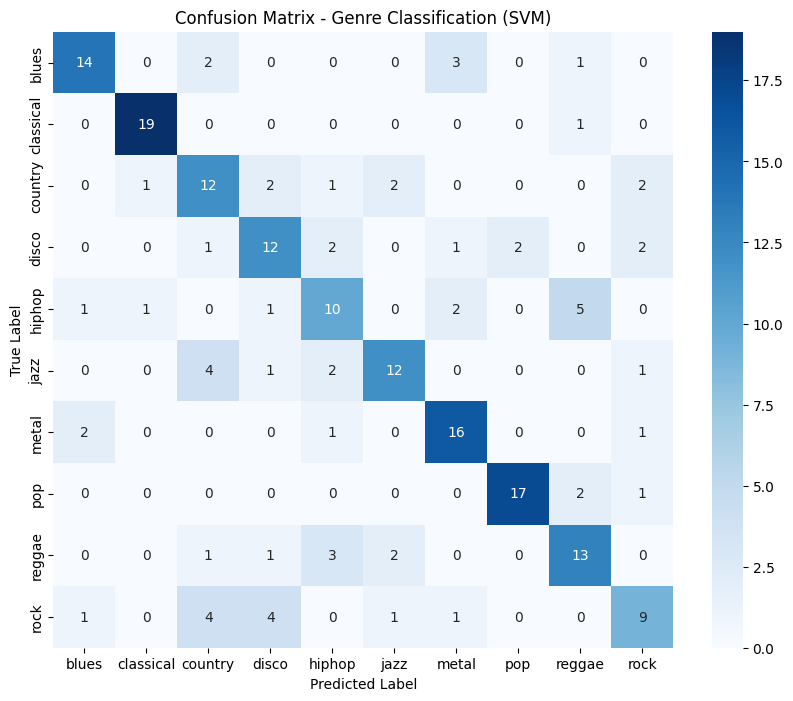

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=GENRES, yticklabels=GENRES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Genre Classification (SVM)")
plt.show()